In [2]:
%matplotlib inline
import deepdish as dd
import h5py
import numpy as np
from galaxy_analysis.plot.plot_styles import *
import matplotlib.pyplot as plt
from galaxy_analysis.utilities import utilities

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import glob


fsize = 21
rc('text',usetex=False)
rc('font',size=fsize)


yr_s = 3.154E7

In [19]:
def dlist_asarray(dict_list, key_list, as_list = False):
    
    res = [None]*len(dict_list)
    #print(len(dict_list))
    
    for i,d in enumerate(dict_list):
        res[i] = extract_nested_dict(d, key_list)
        
    if as_list:
        return res
    
    return np.array(res)
    
    
def extract_nested_dict(d, key_list):
    
    if isinstance(key_list, str):
        return d[key_list]
    elif len(key_list) == 1:
        return d[key_list[0]]
    
    return extract_nested_dict( d[key_list[0]], key_list[1:])

class DataContainer:
    
    def __init__(self, directory, file_list = None, self_contained = False,
                 name = None, data_file_name = "*_galaxy_data.h5"):
        
        self.directory = directory
        
        self.self_contained = self_contained # sets if the "file list" is a list
                                             # files to be loaded (False) or 
                                             # a list of data dump names (True)
                                             # contained within the data_file_name
        
        self.file_list      = file_list
        self.data_file_name = data_file_name

        self._data = {} # stores data
        
        if (self.file_list is None):
            
            if not self.self_contained:
                self.file_list = np.sort(glob.glob(directory + '/' + self.data_file_name))
            else:
                raise NotImplementedError 
      
    
        self.known_paths = {'SFR'  : '/time_data/SFR',
                            'time' : '/meta_data/Time',
                            'meta_data' : '/meta_data',
                           }
        
        
        
        if name is None:
            self.name = directory
        else:
            self.name = name
            
        self.load_loading_table()
            
            
        # do some prep
        self.load_field(self.known_paths['time'],label='time',
                        reload=True, to_array=True)
        
        self.load_field(self.known_paths['meta_data'], label='meta_data',
                        reload=True, to_array=False)
                
        # pre-load the easy things
        for k in self._data['meta_data'][0].keys():
            self._data[k] = dlist_asarray( self._data['meta_data'], [k])
    
        return
        
    def data(self, label):
        
        if label in self.loaded_fields():
            return self._data[label]
        
        if label in self.known_paths:
            path = self.known_paths[label]
        
        self.load_field(path, label=label)
        
        return self._data[label]
    
    
    def load_loading_table(self):
        # load (if available) loading table from LiBryan2019 
        
        loading_table = glob.glob( self.directory + '/*loading_table.dat')
        
        if len(loading_table) == 0:
            self.loading_table_values = None
            print("Loading data table not found for ", self.name)
            return
        
        
        keys = ["Eta_mass", "Eta_mass_hot", "Eta_mass_cold", 
                "Eta_metal", "Eta_metal_hot", "Eta_metal_cold", 
                "Eta_E", "Eta_E_hot", "Eta_E_cold", "Eta_E_hot_cold_ratio",
                "e_s", "e_s_hot", "e_s_cold", "e_s_hot_cold_ratio",
                "Sigma_gas", "Sigma_sfr", "Eta_hot_Eta_Metal_hot_ratio"]
        
        self.loading_table_values = {}
        for k in keys:
            self.loading_table_values[k] = -999
            
        with open(loading_table[0]) as fp:
            count = 0
            for line in fp:
                self.loading_table_values[ keys[count] ] = float(line.split(" ")[-1])
                count = count + 1
    
        return
            
    
    def load_single(self, path, filename = None, index = None):
        
        if (filename is None) and (index is None):
            print("Must provide either name of file or index in file_list")
            raise ValueError
            
        if (filename is None):
            filename = self.file_list[index]
            
        if path in self.known_paths.keys(): # assume path = label if true
            path = self.known_paths[path]
                
        
        return dd.io.load(filename, path)
        
        
    def load_field(self, path, label = None, reload = False,
                               to_array    = True):
        """
        Grab data from file given dictionary path. 
        
        path   :  str
            string or list of strings to pass to deepdish
            to selectively load the desired field. 
        label  : str, optional
            optional alias to be used in place of path
            in self.data dictionary. Default: none (set to path)
        reload  : bool, optional
            By default, just returns data in self.data if 
            label exists already. Otherwise reloads and overwrites.
            Default : False
        to_array: bool, optional
            By default, if retrieved data are just single scalars
            it is stored as a numpy array. Otherwise it is kept 
            as a list. Set this to override default behavior
            and keep as list
        """
        
        if (label is None):
            label = path
                          
        if (path is None):
            path = self.known_paths[label]
            
        if not reload:
            if label in self._data.keys():
                return self._data[label]
                
        # else - load
        self._data[label] = [0.0]*np.size(self.file_list)
        fail_count = 0
        for i,filename in enumerate(self.file_list):
                          
            try:
                self._data[label][i] = dd.io.load(filename,path)
            except:
                self._data[label][i] = None
                fail_count += 1
                          
            if fail_count > 10:
                print("Failed more than %i times loading with path %s and label %s"%(fail_count, path, label))
                raise RuntimeError
        
        if to_array:
            self._data[label] = np.array(self._data[label])
                          
        return self._data[label]
            
    def loaded_fields(self):
        return self._data.keys()
        
        
        

In [20]:
fid_dir  = '/home/aemerick/work/enzo_runs/leo_p/fiducial/sn_H2atten_H2sh'
work_dir = '/home/aemerick/work/enzo_runs/leo_p/run11_30km_3pc_H2'

filepaths = {'sn_only' : work_dir + '/sn_only',
             'fiducial' : fid_dir + '/../3pc_H2', 'fiducial-1.8pc' : fid_dir}
             

labels    = {'sn_only' : 'SN-only',
             'ion_no-otrad-sn' : 'Ionization only',
             'otrad_ion-no-sn' : 'Radiation only',
             'otrad_no-ion-sn' : 'PE+LW only',
             'shortrad'        : 'shortrad',
             'shortrad_72pc'   : 'shortrad-72pc',
             'sn_ion-no-otrad' : 'SN + Ion',
             'sn_otrad_no-ion' : 'SN + PE+LW',
             'sn_otrad_ion_RPx2' : 'RPx2',
             'sn_otrad_ion_RPx5' : 'RPx5',
             'sn_otrad_ion_noRP'     : 'RPx0',
             'fiducial-1.8pc' : 'Fiducial-1.8pc',
             'fiducial'      : 'Fiducial'}

markers = {'sn_only' : 'o',
           'otrad_ion-no-sn' : 'S',
           'otrad_no-ion-sn' : 'D',
            'sn_ion-no-otrad' : 'd'}


base_comparison = ['fiducial', 'sn_ion-no-otrad', 'sn_otrad_no-ion', 'sn_only', 
                   'otrad_ion-no-sn', 'ion_no-otrad-sn', 'otrad_no-ion-sn', 'sn_otrad_ion_noRP', 'shortrad']

sn_runs = ['fiducial','sn_ion-no-otrad','sn_otrad_no-ion','sn_only']
no_sn_runs = ['otrad_ion-no-sn','ion_no-otrad-sn','otrad_no-ion-sn']
misc_runs  = ['sn_otrad_ion_noRP','shortrad']

colors = {}
for i,k in enumerate(labels.keys()):
    colors[k] = "C%0i"%(i)
colors['fiducial'] = 'black'
#
#colors['sn_otrad_ion_noRP'] = 'black'

lstyles = {}
for i,k in enumerate(labels.keys()):
    lstyles[k] = '-'
lstyles['sn_otrad_ion_noRP'] = ':'


if True:
    # try some color scheme
    colors['fiducial'] = 'black';        lstyles['fiducial'] = '-'
    colors['sn_ion-no-otrad'] = 'C1'; lstyles['sn_ion-no-otrad'] = '-'
    colors['sn_otrad_no-ion'] = 'C1'; lstyles['sn_otrad_no-ion'] = '--'
    colors['sn_only']  = 'C1';        lstyles['sn_only'] = ':'
    
    colors['otrad_ion-no-sn'] = 'C3';  lstyles['otrad_ion-no-sn'] = '-'
    colors['otrad_no-ion-sn'] = 'C3';  lstyles['otrad_no-ion-sn'] = '--'
    colors['ion_no-otrad-sn'] = 'C3';  lstyles['ion_no-otrad-sn'] = ':' 
    
    colors['shortrad'] = 'C0'
    colors['sn_otrad_ion_noRP'] = 'C2'; lstyles['sn_otrad_ion_noRP'] = '-'
    colors['sn_otrad_ion_RPx2'] = 'C2'; lstyles['sn_otrad_ion_RPx2'] = '--'
    colors['sn_otrad_ion_RPx5'] = 'C2'; lstyles['sn_otrad_ion_RPx5'] = ':'

else:
    colors['fiducial']        =  magma(0.8);        lstyles['fiducial'] = '-'
    colors['sn_ion-no-otrad'] =  magma(0.6); lstyles['sn_ion-no-otrad'] = '-'
    colors['sn_otrad_no-ion'] =  magma(0.4); lstyles['sn_otrad_no-ion'] = '-'
    colors['sn_only']         =  magma(0.2);        lstyles['sn_only'] = '-'
    
    colors['otrad_ion-no-sn'] = viridis(0.8);  lstyles['otrad_ion-no-sn'] = '-'
    colors['otrad_no-ion-sn'] = viridis(0.6);  lstyles['otrad_no-ion-sn'] = '-'
    colors['ion_no-otrad-sn'] = viridis(0.4);  lstyles['ion_no-otrad-sn'] = '-' 
    
    colors['shortrad'] = 'C0'
    colors['sn_otrad_ion_noRP'] = 'C1'; lstyles['sn_otrad_ion_noRP'] = '-'
    colors['sn_otrad_ion_RPx2'] = 'C1'; lstyles['sn_otrad_ion_RPx2'] = '--'
    colors['sn_otrad_ion_RPx5'] = 'C1'; lstyles['sn_otrad_ion_RPx5'] = ':'


for l in labels:
    if not (l in filepaths.keys()):
        filepaths[l] = work_dir + '/' + l
        
#
#
# plot limits for consistency
#
#
global_time_lim = [0.0, 750.0]

In [21]:
all_data = {}

runs_to_load = labels.keys()


for k in runs_to_load:
    print(k)
    all_data[k] = DataContainer( filepaths[k], name = k)
#all_data['fiducial'] = DataContainer(filepaths['fiducial'], name = 'fiducial')    

sn_only
ion_no-otrad-sn
Loading data table not found for  ion_no-otrad-sn
otrad_ion-no-sn
otrad_no-ion-sn
shortrad
Loading data table not found for  shortrad
shortrad_72pc
Loading data table not found for  shortrad_72pc
sn_ion-no-otrad
sn_otrad_no-ion
Loading data table not found for  sn_otrad_no-ion
sn_otrad_ion_RPx2
Loading data table not found for  sn_otrad_ion_RPx2
sn_otrad_ion_RPx5
Loading data table not found for  sn_otrad_ion_RPx5
sn_otrad_ion_noRP
Loading data table not found for  sn_otrad_ion_noRP
fiducial-1.8pc
Loading data table not found for  fiducial-1.8pc
fiducial
Loading data table not found for  fiducial


In [22]:
for run in labels.keys():
    t = all_data[run].load_field('time')
    print("%30s      %5.2f Myr"%(run, t[-1]-t[0]))

                       sn_only      121.00 Myr
               ion_no-otrad-sn      920.00 Myr
               otrad_ion-no-sn      857.00 Myr
               otrad_no-ion-sn      521.00 Myr
                      shortrad      271.00 Myr
                 shortrad_72pc      256.00 Myr
               sn_ion-no-otrad      767.00 Myr
               sn_otrad_no-ion      421.00 Myr
             sn_otrad_ion_RPx2      757.00 Myr
             sn_otrad_ion_RPx5      471.00 Myr
             sn_otrad_ion_noRP      739.00 Myr
                fiducial-1.8pc      899.00 Myr
                      fiducial      649.00 Myr


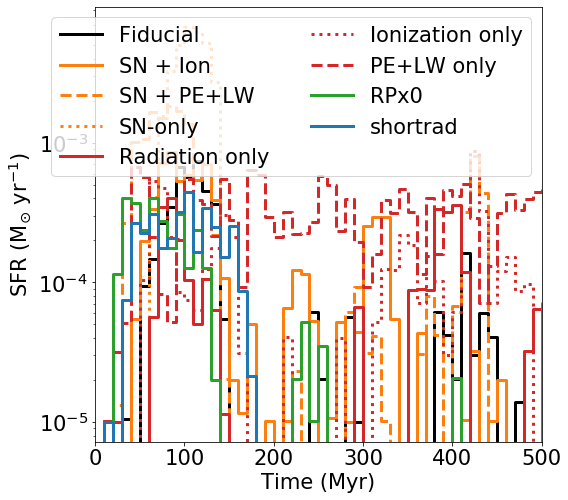

In [40]:
#
# plot a SFR comparison
#


fig, ax = plt.subplots()
fig.set_size_inches(8,8)

runs_to_plot = base_comparison
for i,run in enumerate(runs_to_plot):
    #t = all_data[run].data('time')
    
    #t = t - t[0]
    
    # _1 or #_100 for 1 Myr and 100 Myr averaged SFRs
    t   = all_data[run].load_single('/time_data/time', index = -1) / 1.0E6
    SFR = all_data[run].load_single('/time_data/SFR',index = -1)
    
   # print(np.shape(t),np.shape(SFR[:-1])) 
    new_t = np.array(list(t) + [t[-1] + (t[-1]-t[-2])])

    t,SFR = utilities.simple_rebin(new_t-new_t[0], SFR, 10.0, method='average')    
    if run == 'fiducial':
        color = 'black'
    else:
        color = "C%0i"%(i)    
    ax.step(t[:-1], SFR, label = labels[run], lw = 3, where = 'post', color = colors[run], ls=lstyles[run])
    #ax.plot(t[:-1], SFR, label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])
    
ax.set_xlabel(r'Time (Myr)')
ax.set_ylabel(r'SFR (M$_{\odot}$ yr$^{-1}$)')
ax.semilogy()

ax.legend(loc='best',ncol = 2)

ax.set_xlim(global_time_lim)
#ax.set_ylim()
fig.savefig('physics_comparison_sfr.png')

x = all_data['sn_only']
x.load_field('/gas_meta_data/masses/Disk/Total Tracked Metals') / x.load_field('M_gas')

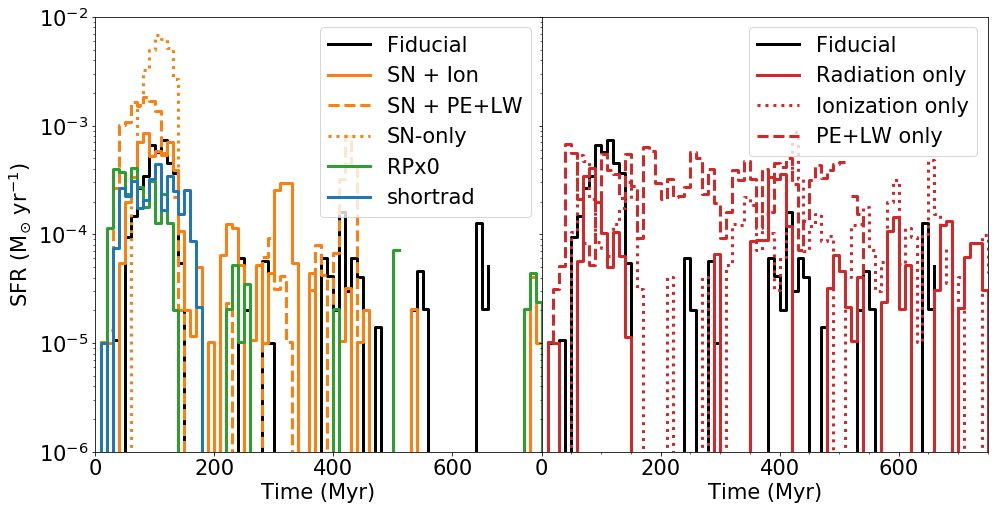

In [63]:
#
# plot a SFR comparison
#


fig, axes = plt.subplots(1,2,sharey=True)
fig.set_size_inches(16,8)

fig.subplots_adjust(wspace=0)

runs_to_plot = base_comparison

ax = axes[0]
runs_to_plot = sn_runs+ misc_runs
for i,run in enumerate(runs_to_plot):
    #t = all_data[run].data('time')
    
    #t = t - t[0]
    
    # _1 or #_100 for 1 Myr and 100 Myr averaged SFRs
    t   = all_data[run].load_single('/time_data/time', index = -1) / 1.0E6
    SFR = all_data[run].load_single('/time_data/SFR',index = -1)
    
   # print(np.shape(t),np.shape(SFR[:-1])) 
    new_t = np.array(list(t) + [t[-1] + (t[-1]-t[-2])])

    t,SFR = utilities.simple_rebin(new_t-new_t[0], SFR, 10.0, method='average')    
    if run == 'fiducial':
        color = 'black'
    else:
        color = "C%0i"%(i)    
    ax.step(t[:-1], SFR, label = labels[run], lw = 3, where = 'post', color = colors[run], ls=lstyles[run])
    #ax.plot(t[:-1], SFR, label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])
    
    plt.minorticks_on()


ax = axes[1]
runs_to_plot =  ['fiducial'] + no_sn_runs 
for i,run in enumerate(runs_to_plot):
    #t = all_data[run].data('time')
    
    #t = t - t[0]
    
    # _1 or #_100 for 1 Myr and 100 Myr averaged SFRs
    t   = all_data[run].load_single('/time_data/time', index = -1) / 1.0E6
    SFR = all_data[run].load_single('/time_data/SFR',index = -1)
    
   # print(np.shape(t),np.shape(SFR[:-1])) 
    new_t = np.array(list(t) + [t[-1] + (t[-1]-t[-2])])

    #SFR[SFR<1.0E-6]=
    
    t,SFR = utilities.simple_rebin(new_t-new_t[0], SFR, 10.0, method='average')    
    if run == 'fiducial':
        color = 'black'
    else:
        color = "C%0i"%(i)    
    ax.step(t[:-1], SFR, label = labels[run], lw = 3, where = 'post', color = colors[run], ls=lstyles[run])
    #ax.plot(t[:-1], SFR, label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])
   
    plt.minorticks_on()
    
for ax in axes:
    ax.set_xlabel(r'Time (Myr)')
    ax.semilogy()
    ax.set_xlim(global_time_lim)
    ax.set_ylim(1.0E-6,1.0E-2)
axes[0].legend(ncol = 1,loc = 'upper right')
axes[1].legend(loc='best',ncol = 1)
axes[0].set_ylabel(r'SFR (M$_{\odot}$ yr$^{-1}$)')



#ax.set_ylim()
fig.savefig('physics_comparison_sfr_2.png')

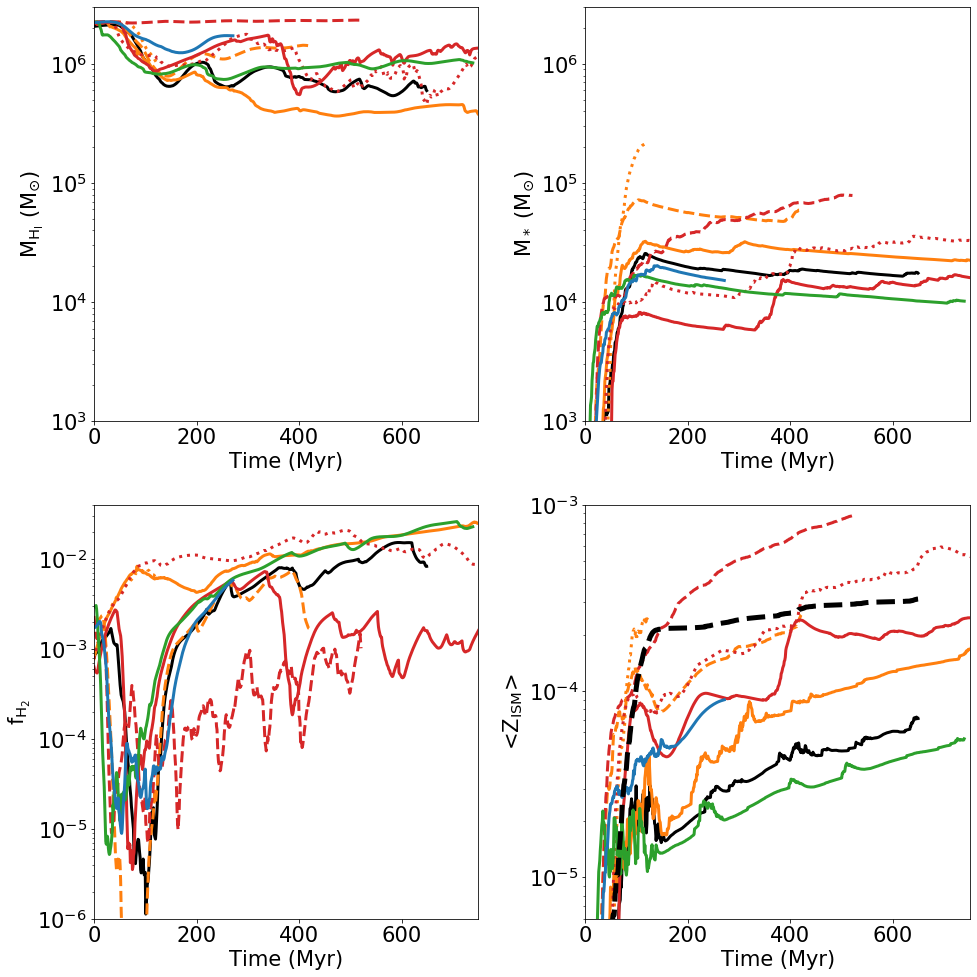

In [84]:
#
# plot a mass comparison
#


fig, axes = plt.subplots(2,2)
fs = 7
fig.set_size_inches(fs*2,fs*2)


ax_fields = ['M_HI','M_star','M_H2_total','Z']
ax_labels = [r'M$_{\rm H_I}$ (M$_{\odot}$)', r'M$_{\rm *}$ (M$_{\odot}$)',
             #r'M$_{\rm H_2}$ (M$_{\odot}$)', 
             r'f$_{\rm H_2}$', 
             r'<Z$_{\rm ISM}$>']
ylims = [ [1.0E3,3.0E6], [1.0E3,3.0E6], [1.0E-6,4.0E-2], [6.0E-6,1.0E-3]]             

runs_to_plot = base_comparison


index = 0
axi = axj = 0
for ax1 in axes:
    
    axj = 0
    for ax2 in ax1:
        
        ax_index = (axi,axj)

        for i,run in enumerate(runs_to_plot):
    #t = all_data[run].data('time')
    
    #t = t - t[0]
       
            x = all_data[run].data('time')
            
            if ax_fields[index] == 'Z':
                y = all_data[run].load_field('/gas_meta_data/masses/Disk/Total Tracked Metals') /\
                    all_data[run].data('M_gas')
                
               # y = all_data[run].data('M_star')
                
            elif ax_fields[index] == 'M_H2_total':
                y = all_data[run].data('M_H2_total') / all_data[run].data('M_gas')
            else:
                
                y = all_data[run].data(ax_fields[index])
            
            x = x - x[0]

            ax2.plot(x,y, label = labels[run], lw = 3, color = colors[run], ls = lstyles[run])

        ax2.set_ylabel(ax_labels[index])            
        ax2.set_xlabel(r'Time (Myr)')
        ax2.set_xlim(global_time_lim)
        ax2.semilogy()
        ax2.set_ylim(ylims[index])
        
        ax2.tick_params(axis='x', which='minor', bottom=True)
        #ax2.tick_params(axis='y', which='minor', bottom=True)

        
        
        index = index + 1
 
             
        axj = axj + 1
        
    axi = axi + 1
    
    
closed_box = True

# overplot closed box model for fiducial run
if closed_box:
    y = all_data['fiducial'].load_field('/gas_meta_data/masses/OutsideBox/Total Tracked Metals') +\
        all_data['fiducial'].load_field('/gas_meta_data/masses/FullBox/Total Tracked Metals')
    
    y = y / all_data['fiducial'].load_field('M_gas')[0]
    x = all_data['fiducial'].load_field('time')
    
    axes[(1,1)].plot(x - x[0], y, color = 'black', ls = '--', lw = 5, label = 'Closed Box')
   # axes[(1,1)].legend(loc='best')
    

#axes[(0,0)].legend(loc='best',ncol=2)


plt.tight_layout()

fig.savefig("physics_comparison_masses.png")

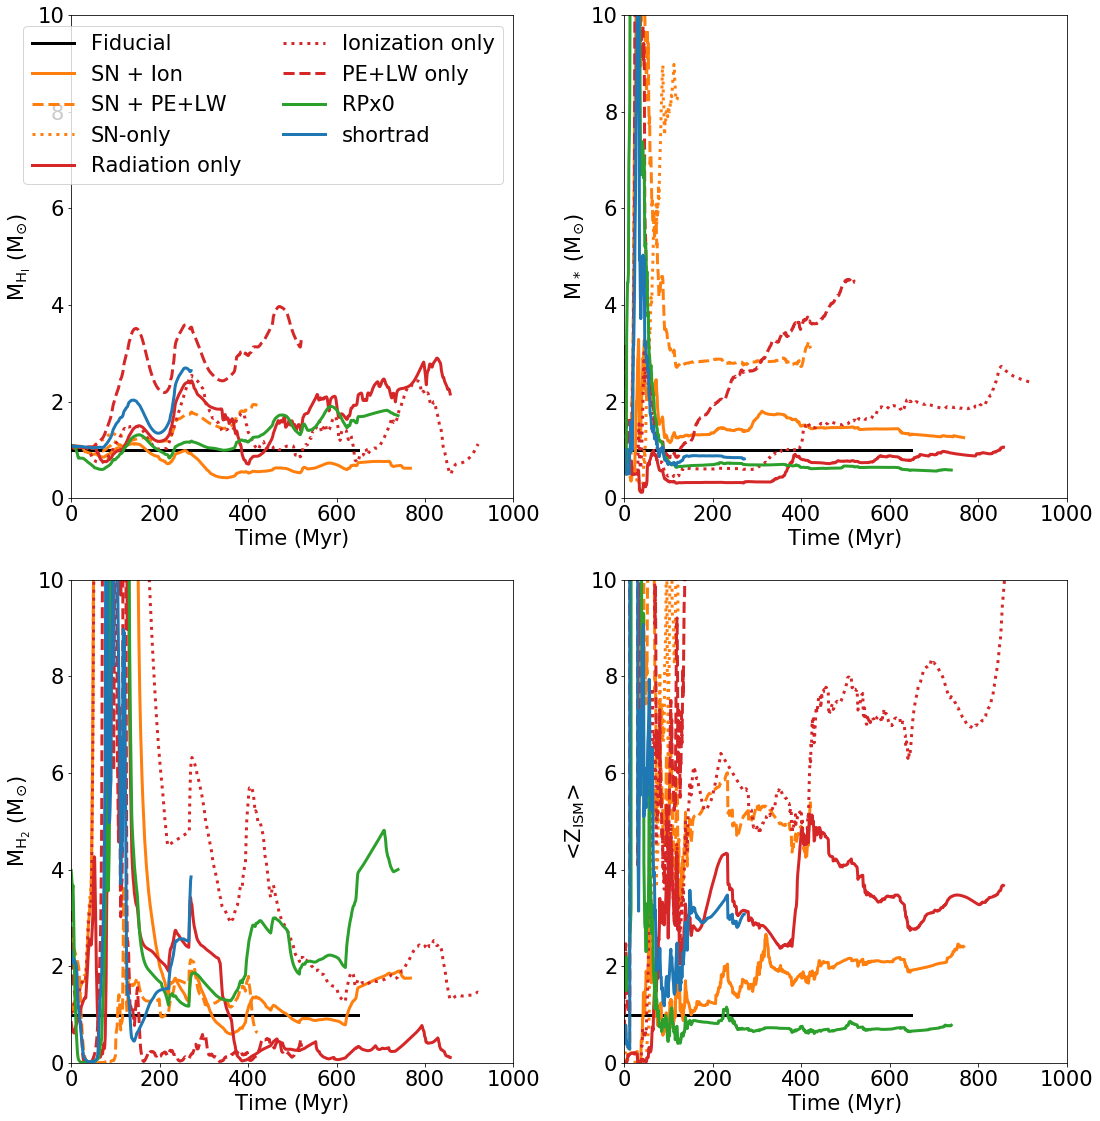

In [68]:
#
# plot a mass comparison
#


fig, axes = plt.subplots(2,2)
fs = 8
fig.set_size_inches(fs*2,fs*2)


ax_fields = ['M_HI','M_star','M_H2_total','Z']
ax_labels = [r'M$_{\rm H_I}$ (M$_{\odot}$)', r'M$_{\rm *}$ (M$_{\odot}$)',
             r'M$_{\rm H_2}$ (M$_{\odot}$)', r'<Z$_{\rm ISM}$>']
ylims = [ [1.0E4,6.0E6], [1.0E3,3.0E5], [1.0,5.0E4], [1.0E-5,3.0E-3]]  


ylims = [ [1.0E-2,1.0E2],  [1.0E-2,1.0E2], [1.0E-2,1.0E2], [1.0E-2,1.0E2] ]            


runs_to_plot = base_comparison


index = 0
axi = axj = 0
for ax1 in axes:
    
    axj = 0
    for ax2 in ax1:
        
        ax_index = (axi,axj)

        for i,run in enumerate(runs_to_plot):
    #t = all_data[run].data('time')
    
    #t = t - t[0]
       
            x = all_data[run].data('time')
            x_fiducial = all_data['fiducial'].data('time')
            
            if ax_fields[index] == 'Z':
                y = all_data[run].load_field('/gas_meta_data/masses/Disk/Total Tracked Metals') /\
                    all_data[run].data('M_gas')
                
                
                y_fiducial = all_data['fiducial'].load_field('/gas_meta_data/masses/Disk/Total Tracked Metals') /\
                    all_data['fiducial'].data('M_gas')
            else:
                y = all_data[run].data(ax_fields[index])
                
                y_fiducial   = all_data['fiducial'].data(ax_fields[index])
            
            
                    
            x = x - x[0]
            x_fiducial = x_fiducial - x_fiducial[0]
            
            f_fiducial = lambda t : np.interp(t, x_fiducial, y_fiducial)
            
            y = y / f_fiducial(x)

            ax2.plot(x,y, label = labels[run], lw = 3, color = colors[run], ls = lstyles[run])

        ax2.set_ylabel(ax_labels[index])            
        ax2.set_xlabel(r'Time (Myr)')
        ax2.set_xlim(0.0,1000.0)
        #ax2.semilogy()
        ax2.set_ylim(0.0,10.0)
        #ax2.set_ylim(ylims[index])
        
        
        
        
        index = index + 1

        
             
        axj = axj + 1
        
    axi = axi + 1

axes[(0,0)].legend(loc='best',ncol=2)


plt.tight_layout()

fig.savefig("normalized_physics_comparison_masses.png")

0.06894476295900266
0.413715167032098


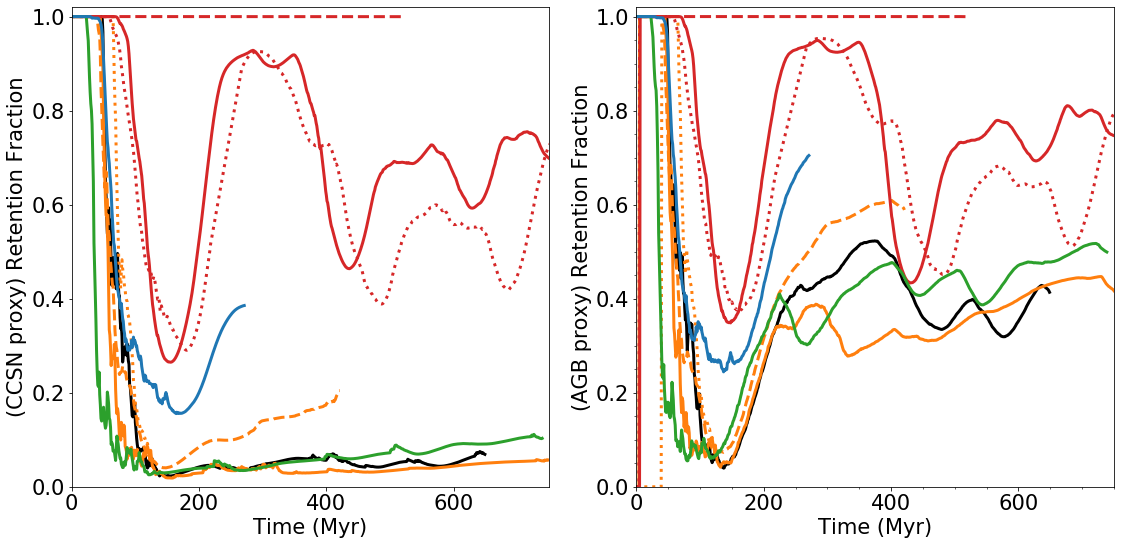

In [87]:
#
# plot a SFR comparison
#


fig, ax = plt.subplots(1,2)
fig.set_size_inches(16,8)

plt.minorticks_on()


runs_to_plot = base_comparison
for i,run in enumerate(runs_to_plot):
    #t = all_data[run].data('time')
    
    #t = t - t[0]
    
    # _1 or #_100 for 1 Myr and 100 Myr averaged SFRs
    t   = all_data[run].data('time')
    t = t - t[0]
    
    M_tot = all_data[run].load_field('/gas_meta_data/masses/FullBox/O') +\
              all_data[run].load_field('/gas_meta_data/masses/OutsideBox/O')
    M_disk = all_data[run].load_field('/gas_meta_data/masses/Disk/O')
    ax[0].plot(t, ( M_disk / M_tot),
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])
    if run == 'fiducial':
        print((M_disk/M_tot)[-1])    

    M_tot = all_data[run].load_field('/gas_meta_data/masses/FullBox/Ba') +\
              all_data[run].load_field('/gas_meta_data/masses/OutsideBox/Ba')
    M_disk = all_data[run].load_field('/gas_meta_data/masses/Disk/Ba')
    
    #M_disk[t < 150] = None
    
    if run == 'fiducial':
        print((M_disk/M_tot)[-1])
    
    ax[1].plot(t, (M_disk / M_tot),
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])    

for a in ax:
    a.set_xlabel(r'Time (Myr)')
    a.set_xlim(global_time_lim)
    a.set_ylim(0, 1.02) #   'shortrad',
ax[0].set_ylabel(r'(CCSN proxy) Retention Fraction')
ax[1].set_ylabel(r'(AGB proxy) Retention Fraction')

#ax.semilogy()

#ax[1].legend(loc='lower right',ncol = 2)
plt.minorticks_on()
plt.tight_layout()
#ax.set_ylim()

fig.savefig("physics_comparison_retention.png")

0.29321366612733074
0.3367437013535525


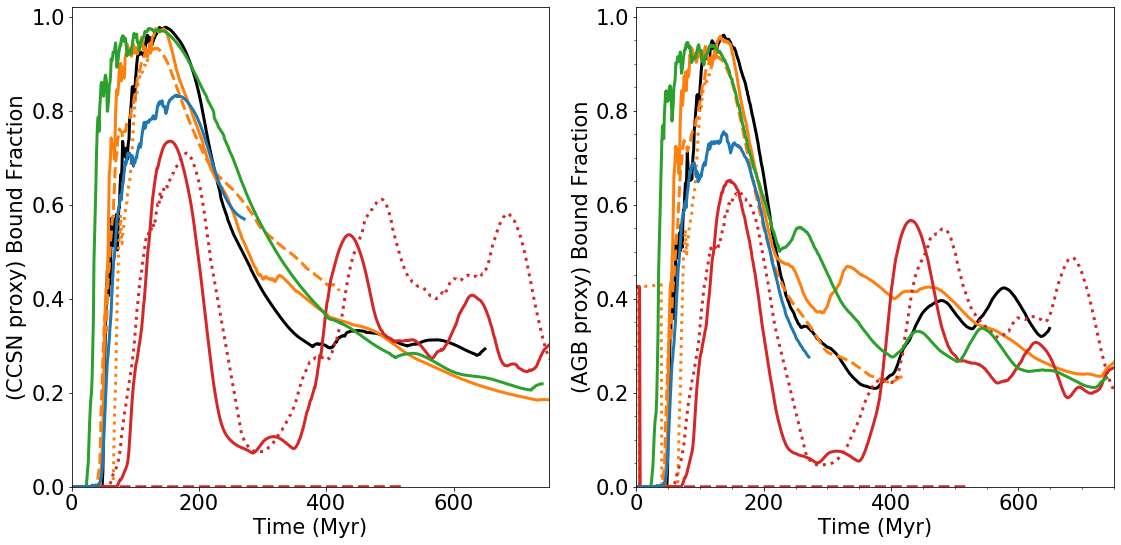

In [90]:
#
# plot a SFR comparison
#


fig, ax = plt.subplots(1,2)
fig.set_size_inches(16,8)

plt.minorticks_on()


runs_to_plot = base_comparison
for i,run in enumerate(runs_to_plot):
    #t = all_data[run].data('time')
    
    #t = t - t[0]
    
    # _1 or #_100 for 1 Myr and 100 Myr averaged SFRs
    t   = all_data[run].data('time')
    t = t - t[0]
    
    M_tot = all_data[run].load_field('/gas_meta_data/masses/FullBox/O') +\
              all_data[run].load_field('/gas_meta_data/masses/OutsideBox/O')
    M_disk = all_data[run].load_field('/gas_meta_data/masses/Halo/O')
    ax[0].plot(t, ( M_disk / M_tot),
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])
    if run == 'fiducial':
        print((M_disk/M_tot)[-1])    

    M_tot = all_data[run].load_field('/gas_meta_data/masses/FullBox/Ba') +\
              all_data[run].load_field('/gas_meta_data/masses/OutsideBox/Ba')
    M_disk = all_data[run].load_field('/gas_meta_data/masses/Halo/Ba')
    
    #M_disk[t < 150] = None
    
    if run == 'fiducial':
        print((M_disk/M_tot)[-1])
    
    ax[1].plot(t, (M_disk / M_tot),
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])    

for a in ax:
    a.set_xlabel(r'Time (Myr)')
    a.set_xlim(global_time_lim)
    a.set_ylim(0, 1.02) #   'shortrad',
ax[0].set_ylabel(r'(CCSN proxy) Bound Fraction')
ax[1].set_ylabel(r'(AGB proxy) Bound Fraction')

#ax.semilogy()

#ax[1].legend(loc='lower right',ncol = 2)
plt.minorticks_on()
plt.tight_layout()
#ax.set_ylim()

fig.savefig("physics_comparison_gravbound.png")

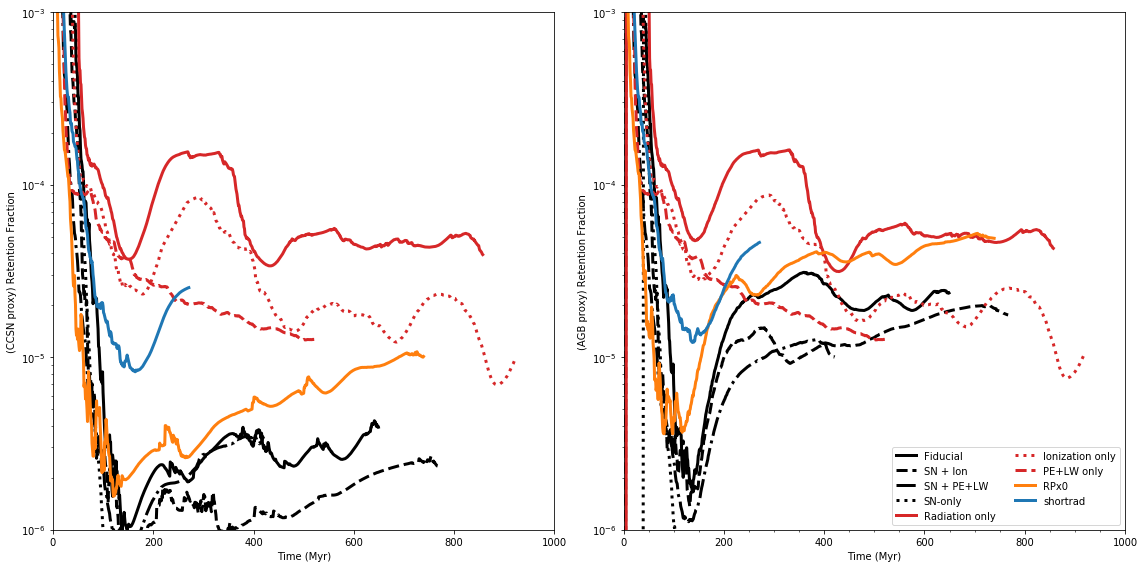

In [18]:
#
# plot a SFR comparison
#


fig, ax = plt.subplots(1,2)
fig.set_size_inches(16,8)

plt.minorticks_on()


runs_to_plot = base_comparison
for i,run in enumerate(runs_to_plot):
    #t = all_data[run].data('time')
    
    #t = t - t[0]
    
    # _1 or #_100 for 1 Myr and 100 Myr averaged SFRs
    t   = all_data[run].data('time')
    t = t - t[0]
    
    M_star = all_data[run].load_field('M_star')
    
    M_tot = all_data[run].load_field('/gas_meta_data/masses/FullBox/O') +\
              all_data[run].load_field('/gas_meta_data/masses/OutsideBox/O')
    M_disk = all_data[run].load_field('/gas_meta_data/masses/Disk/O')
    ax[0].plot(t, ( M_disk / M_star / M_tot),
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])

    M_tot = all_data[run].load_field('/gas_meta_data/masses/FullBox/Ba') +\
              all_data[run].load_field('/gas_meta_data/masses/OutsideBox/Ba')
    M_disk = all_data[run].load_field('/gas_meta_data/masses/Disk/Ba')
    
    #M_disk[t < 150] = None
    
    ax[1].plot(t, (M_disk / M_star / M_tot),
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])    

for a in ax:
    a.set_xlabel(r'Time (Myr)')
    a.set_xlim(0.0, 1000.0)
    a.semilogy()
    a.set_ylim(1.0E-6,1.0E-3)
  #  a.set_ylim() #   'shortrad',
ax[0].set_ylabel(r'(CCSN proxy) Retention Fraction')
ax[1].set_ylabel(r'(AGB proxy) Retention Fraction')

#ax.semilogy()

ax[1].legend(loc='lower right',ncol = 2)
plt.minorticks_on()
plt.tight_layout()
#ax.set_ylim()

fig.savefig("physics_comparison_yield.png")

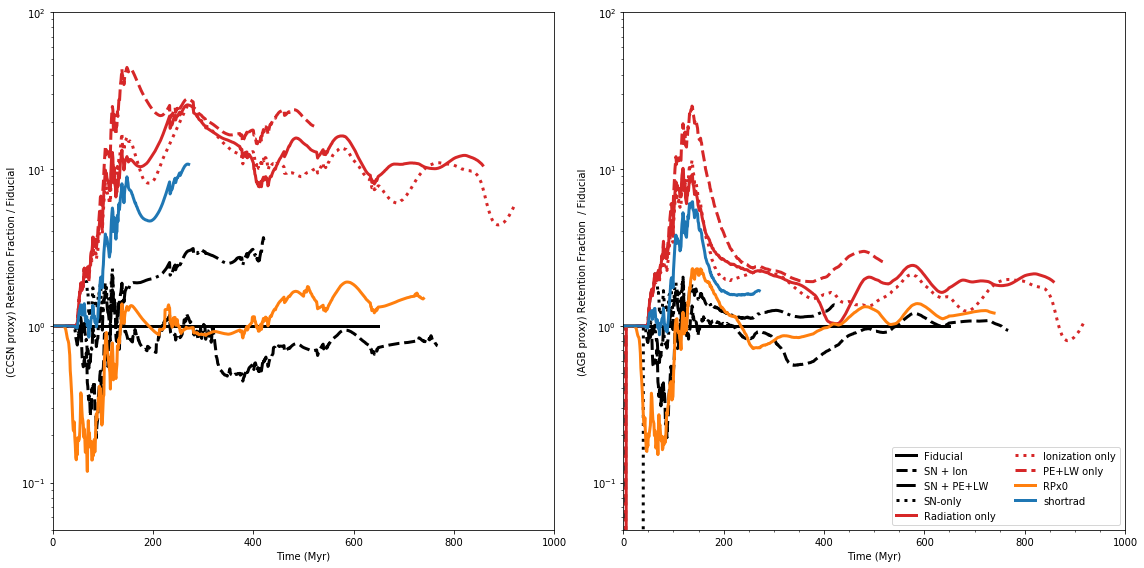

In [9]:
#
# plot a SFR comparison
#


fig, ax = plt.subplots(1,2)
fig.set_size_inches(16,8)

plt.minorticks_on()


runs_to_plot = base_comparison
for i,run in enumerate(runs_to_plot):
    #t = all_data[run].data('time')
    
    #t = t - t[0]
    
    # _1 or #_100 for 1 Myr and 100 Myr averaged SFRs
    t   = all_data[run].data('time')
    x_fiducial = all_data['fiducial'].data('time')
    
    t = t - t[0]
    x_fiducial = x_fiducial - x_fiducial[0]
    
    
    M_tot = all_data[run].load_field('/gas_meta_data/masses/FullBox/O') +\
              all_data[run].load_field('/gas_meta_data/masses/OutsideBox/O')
    M_disk = all_data[run].load_field('/gas_meta_data/masses/Disk/O')
    y_fiducial = all_data['fiducial'].load_field('/gas_meta_data/masses/Disk/O')/(  
                     all_data['fiducial'].load_field('/gas_meta_data/masses/FullBox/O') +\
                     all_data['fiducial'].load_field('/gas_meta_data/masses/OutsideBox/O'))
    f_fiducial = lambda t : np.interp(t, x_fiducial, y_fiducial)
    
    
    ax[0].plot(t, ( M_disk / M_tot) / (f_fiducial(t)),
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])

    M_tot = all_data[run].load_field('/gas_meta_data/masses/FullBox/Ba') +\
              all_data[run].load_field('/gas_meta_data/masses/OutsideBox/Ba')
    M_disk = all_data[run].load_field('/gas_meta_data/masses/Disk/Ba')
    
    #M_disk[t < 150] = None
    
    y_fiducial = all_data['fiducial'].load_field('/gas_meta_data/masses/Disk/Ba')/(
                     all_data['fiducial'].load_field('/gas_meta_data/masses/FullBox/Ba') +\
                     all_data['fiducial'].load_field('/gas_meta_data/masses/OutsideBox/Ba'))
    
    f_fiducial = lambda t : np.interp(t, x_fiducial, y_fiducial)
    
    ax[1].plot(t, (M_disk / M_tot)/ (f_fiducial(t)),
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])    

for a in ax:
    a.set_xlabel(r'Time (Myr)')
    a.set_xlim(0.0, 1000.0)
    a.set_ylim(5.0E-2,1.0E2) #   'shortrad',
    a.semilogy()
ax[0].set_ylabel(r'(CCSN proxy) Retention Fraction / Fiducial')
ax[1].set_ylabel(r'(AGB proxy) Retention Fraction  / Fiducial')

#ax.semilogy()

ax[1].legend(loc='lower right',ncol = 2)
plt.minorticks_on()
plt.tight_layout()
#ax.set_ylim()

fig.savefig("normalized_physics_comparison_retention.png")

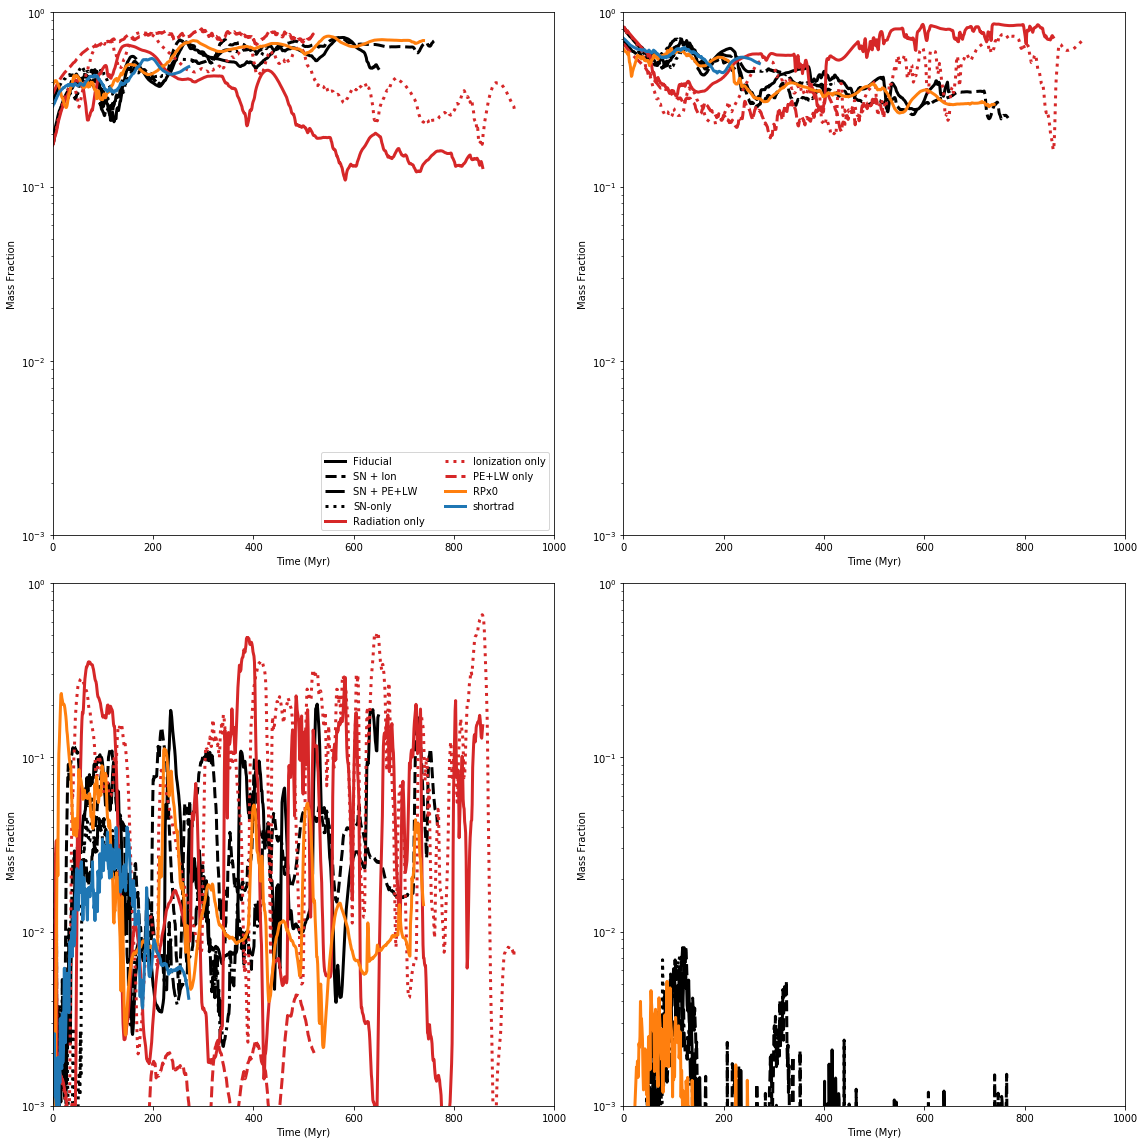

In [10]:
#
# plot a SFR comparison
#


fig, ax = plt.subplots(2,2)
fig.set_size_inches(16,16)



runs_to_plot = base_comparison
for i,run in enumerate(runs_to_plot):
    #t = all_data[run].data('time')
    
    #t = t - t[0]
    
    # _1 or #_100 for 1 Myr and 100 Myr averaged SFRs
    t   = all_data[run].data('time')
    t = t - t[0]
    
    M_tot = all_data[run].load_field('/gas_meta_data/masses/Disk/Total')
    M_phase = all_data[run].load_field('/gas_meta_data/masses/CNM/Total')
    ax[(0,0)].plot(t, ( M_phase / M_tot),
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])

    M_tot = all_data[run].load_field('/gas_meta_data/masses/Disk/Total')
    M_phase = all_data[run].load_field('/gas_meta_data/masses/WNM/Total')
    ax[(0,1)].plot(t, ( M_phase / M_tot),
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])
    
    M_tot = all_data[run].load_field('/gas_meta_data/masses/Disk/Total')
    M_phase = all_data[run].load_field('/gas_meta_data/masses/WIM/Total')
    ax[(1,0)].plot(t, ( M_phase / M_tot),
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])  
    M_tot = all_data[run].load_field('/gas_meta_data/masses/Disk/Total')
    M_phase = all_data[run].load_field('/gas_meta_data/masses/HIM/Total')
    ax[(1,1)].plot(t, ( M_phase / M_tot),
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])      

for ax1 in ax:
    for a in ax1:
        a.set_xlabel(r'Time (Myr)')
        a.set_xlim(0.0, 1000.0)
        a.set_ylim(1.0E-3, 1.0)    
        a.semilogy()
        
        a.set_ylabel(r'Mass Fraction')

#ax.semilogy()

ax[(0,0)].legend(loc='lower right',ncol = 2)

plt.tight_layout()
#ax.set_ylim()

Failed more than 11 times loading with path /gas_meta_data/volume_fraction/Disk/Total and label /gas_meta_data/volume_fraction/Disk/Total


RuntimeError: 

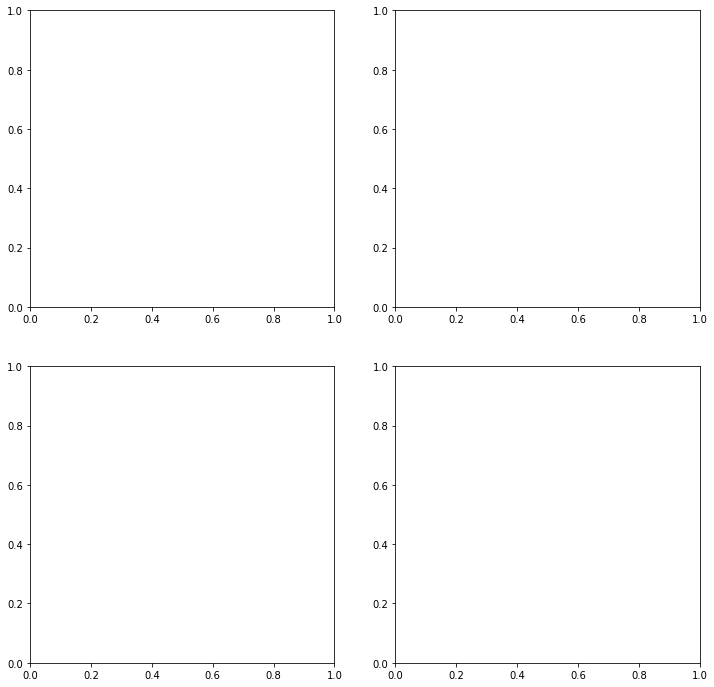

In [11]:
#
# plot a SFR comparison
#


fig, ax = plt.subplots(2,2)
fig.set_size_inches(12,12)



runs_to_plot = base_comparison
for i,run in enumerate(runs_to_plot):
    #t = all_data[run].data('time')
    
    #t = t - t[0]
    
    # _1 or #_100 for 1 Myr and 100 Myr averaged SFRs
    t   = all_data[run].data('time')
    t = t - t[0]
    
    M_tot = all_data[run].load_field('/gas_meta_data/volume_fraction/Disk/Total')
    M_phase = all_data[run].load_field('/gas_meta_data/volume/CNM/Total')
    ax[(0,0)].plot(t, ( M_phase / M_tot),
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])

    M_tot = all_data[run].load_field('/gas_meta_data/volume/Disk/Total')
    M_phase = all_data[run].load_field('/gas_meta_data/volume/WNM/Total')
    ax[(0,1)].plot(t, ( M_phase / M_tot),
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])
    
    M_tot = all_data[run].load_field('/gas_meta_data/volume/Disk/Total')
    M_phase = all_data[run].load_field('/gas_meta_data/volume/WIM/Total')
    ax[(1,0)].plot(t, ( M_phase / M_tot),
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])  
    M_tot = all_data[run].load_field('/gas_meta_data/volume/Disk/Total')
    M_phase = all_data[run].load_field('/gas_meta_data/volume/HIM/Total')
    ax[(1,1)].plot(t, ( M_phase / M_tot),
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])      

for ax1 in ax:
    for a in ax1:
        a.set_xlabel(r'Time (Myr)')
        a.set_xlim(0.0, 1000.0)
        a.set_ylim(1.0E-3, 1.0)    
        a.semilogy()
        
        a.set_ylabel(r'Volume Fraction')

#ax.semilogy()

ax[(0,0)].legend(loc='lower right',ncol = 2)

plt.tight_layout()
#ax.set_ylim()

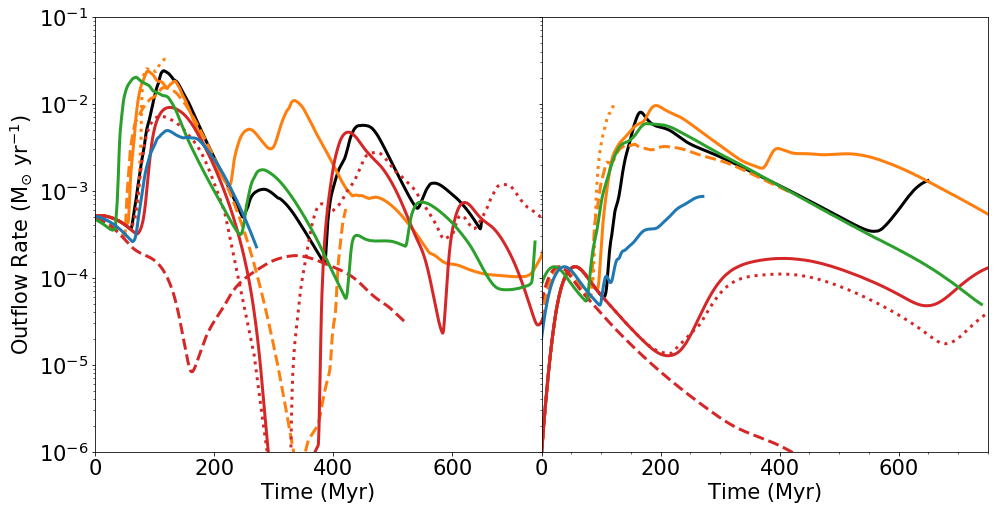

In [114]:
#
# plot a SFR comparison
#


fig, ax = plt.subplots(1,2,sharey=True)
fig.set_size_inches(16,8)

fig.subplots_adjust(wspace=0)

plt.minorticks_on()


runs_to_plot = base_comparison
for i,run in enumerate(runs_to_plot):
    #t = all_data[run].data('time')
    
    #t = t - t[0]
    
    # _1 or #_100 for 1 Myr and 100 Myr averaged SFRs
    t   = all_data[run].data('time')
    t = t - t[0]
    
    outflow = all_data[run].load_field("/gas_profiles/outflow/sphere/('gas', 'cell_mass')")
    

    ax[0].plot(t, outflow[:,0], # bin 0 centered on 0.1 Rvir
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])
    
    ax[1].plot(t, outflow[:,3], # bin 5 centered on Rvir
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])    

for a in ax:
    a.set_xlabel(r'Time (Myr)')
    a.set_xlim(global_time_lim)
    a.set_ylim(1.0E-6,1.0E-1) #   'shortrad',
    a.semilogy()
    
ax[0].set_ylabel(r'Outflow Rate (M$_{\odot}$ yr$^{-1}$)')
#ax[1].set_ylabel(r'Outflow Rate (M$_{\sun}$ yr$^{-1}$)')'

#ax.semilogy()

#ax[1].legend(loc='lower right',ncol = 2)
plt.minorticks_on()
#plt.tight_layout()
#ax.set_ylim()

fig.savefig("physics_comparison_outflow.png")

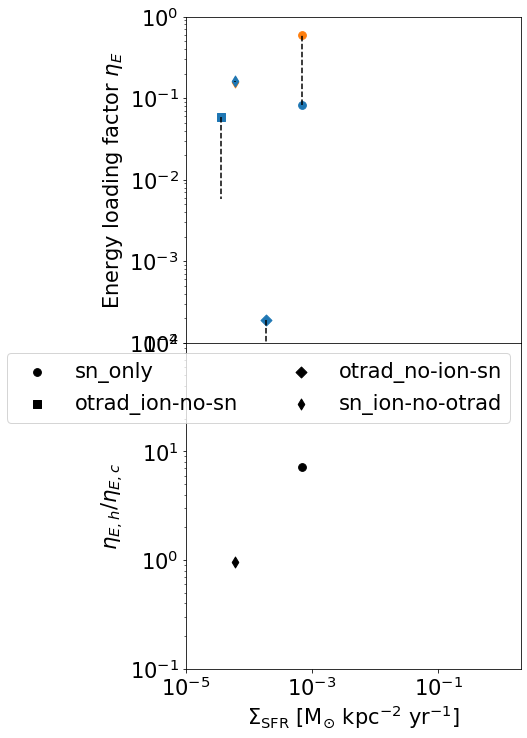

In [49]:
#
#
#
# Li + style loading tables
#
#
fsize = 21
rc('text',usetex=False)
rc('font',size=fsize)



psize = 60
markers = {'sn_only' : 'o',
           'otrad_ion-no-sn' : 's',
           'otrad_no-ion-sn' : 'D',
            'sn_ion-no-otrad' : 'd'}

fig, ax = plt.subplots(2,1,sharex=True)
fig.set_size_inches(6,12)
fig.subplots_adjust(hspace=0)

for run in all_data.keys():
    if all_data[run].loading_table_values is None:
        continue
        
    ax[0].scatter( all_data[run].loading_table_values['Sigma_sfr'],
                   all_data[run].loading_table_values['Eta_E_hot'],
                   color = 'C1', s = psize, label = run, marker=markers[run])
    ax[0].scatter( all_data[run].loading_table_values['Sigma_sfr'],
                   all_data[run].loading_table_values['Eta_E_cold'],
                   color = 'C0', s = psize, label = run, marker = markers[run])
    
    yline = [all_data[run].loading_table_values['Eta_E_cold'],
             all_data[run].loading_table_values['Eta_E_hot']]
    xline = [ all_data[run].loading_table_values['Sigma_sfr']]*2    
   
    if  yline[1] <= 0.0:
        yline[1] = 0.1 * yline[0]
        
        #ax[0].arrow( xline[0], yline[0], dx = 0.0, dy = yline[1] - yline[0],
        #             head_width= 0.1*xline[0],# transform=ax[0].transAxes,
        #             head_length=0.1, fc='k', ec='k')
                      
        
        
    #else:
        
    ax[0].plot( xline,
                    yline,
                    lw = 1.5, color = 'black',
                    ls = '--')
    
    ax[1].scatter( all_data[run].loading_table_values['Sigma_sfr'],
                   all_data[run].loading_table_values['Eta_E_hot_cold_ratio'],
                   color = 'black', s = psize, label = run, marker = markers[run])
    
    #print(run, all_data[run].loading_table_values['Sigma_sfr'])
    #print(run, all_data[run].loading_table_values['Eta_E_hot'])
    #print(run, all_data[run].loading_table_values['Eta_E_cold'])
    
for a in ax:
    a.semilogx()
    a.semilogy()
    a.set_xlim(1.0E-5,2)
    
ax[0].set_ylim(1.0E-4,1.0)
ax[1].set_ylim(0.1,100)
ax[1].legend(loc='best',ncol = 2)
ax[0].set_ylabel(r"Energy loading factor $\eta_E$")
ax[1].set_xlabel(r"$\Sigma_{\rm SFR}$ [M$_{\odot}$ kpc$^{-2}$ yr$^{-1}$]")
ax[1].set_ylabel(r"$\eta_{E,h} / \eta_{E,c}$")
#plt.tight_layout()
fig.savefig("phys_comparison_etaE_hot_cold_SFR.png")


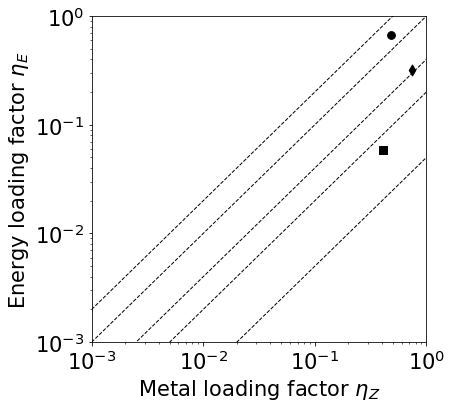

In [66]:
fig,ax = plt.subplots()
fig.set_size_inches(6,6)


xmin, xmax = 999999999,-999999999
ymin, ymax = 999999999,-999999999
for run in all_data.keys():
    if all_data[run].loading_table_values is None:
        continue
    x = all_data[run].loading_table_values['Eta_metal']
    y = all_data[run].loading_table_values['Eta_E']
        
    ax.scatter(x,y,color = 'black', s = psize, label = run, marker=markers[run])

    xmin = np.min([x, xmin])
    xmax = np.max([x, xmax])
    ymin = np.min([y, ymin])
    ymax = np.max([y, ymax])


ax.set_ylabel("Energy loading factor $\eta_E$")
ax.set_xlabel("Metal loading factor $\eta_Z$")
ax.semilogy()
ax.semilogx()

ax.set_xlim(1.0E-3,1.0)
ax.set_ylim(1.0E-3, 1.0)

lw_2 = 1.0

ax.plot( np.array([1.0E-3,1.0]), np.array([2.0E-3,2.0]), lw = lw_2,         ls = '--',color='black')
ax.plot( [1.0E-3,1.0], [1.0E-3,1.0], lw = lw_2, ls = '--',color='black')
ax.plot( [1.0E-3,1.0], [4.0E-4,0.4], lw = lw_2, ls = '--',color='black')
ax.plot( [1.0E-3,1.0], [2.0E-4,0.2], lw = lw_2, ls = '--',color='black')
ax.plot( [1.0E-3,1.0], [5.0E-5,0.05], lw = lw_2, ls = '--',color='black')

fig.savefig("phys_comparison_E_loading_Z_loading.png")

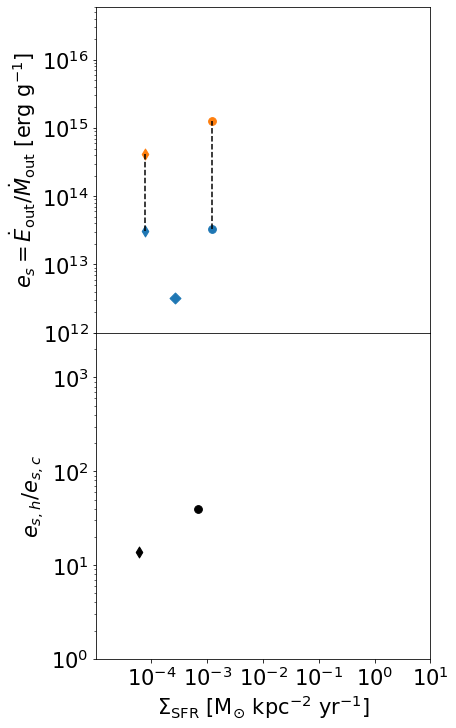

In [72]:
#
#
#
# Li + style loading tables
#
#
fsize = 21
rc('text',usetex=False)
rc('font',size=fsize)



psize = 60
markers = {'sn_only' : 'o',
           'otrad_ion-no-sn' : 's',
           'otrad_no-ion-sn' : 'D',
            'sn_ion-no-otrad' : 'd'}

fig, ax = plt.subplots(2,1,sharex=True)
fig.set_size_inches(6,12)
fig.subplots_adjust(hspace=0)

for run in all_data.keys():
    if all_data[run].loading_table_values is None:
        continue
        
    ax[0].scatter( all_data[run].loading_table_values['Sigma_sfr'],
                   all_data[run].loading_table_values['e_s_hot'],
                   color = 'C1', s = psize, label = run, marker=markers[run])
    ax[0].scatter( all_data[run].loading_table_values['Sigma_sfr'],
                   all_data[run].loading_table_values['e_s_cold'],
                   color = 'C0', s = psize, label = run, marker = markers[run])
    
    yline = [all_data[run].loading_table_values['e_s_cold'],
             all_data[run].loading_table_values['e_s_hot']]
    xline = [ all_data[run].loading_table_values['Sigma_sfr']]*2    
   
    if  yline[1] <= 0.0:
        yline[1] = 0.1 * yline[0]
        
        #ax[0].arrow( xline[0], yline[0], dx = 0.0, dy = yline[1] - yline[0],
        #             head_width= 0.1*xline[0],# transform=ax[0].transAxes,
        #             head_length=0.1, fc='k', ec='k')
                      
        
        
    #else:
        
    ax[0].plot( xline,
                    yline,
                    lw = 1.5, color = 'black',
                    ls = '--')
    
    ax[1].scatter( all_data[run].loading_table_values['Sigma_sfr'],
                   all_data[run].loading_table_values['e_s_hot_cold_ratio'],
                   color = 'black', s = psize, label = run, marker = markers[run])
    
    #print(run, all_data[run].loading_table_values['Sigma_sfr'])
    #print(run, all_data[run].loading_table_values['Eta_E_hot'])
    #print(run, all_data[run].loading_table_values['Eta_E_cold'])
    
for a in ax:
    a.semilogx()
    a.semilogy()
    a.set_xlim(1.0E-5,2)
    
ax[0].set_ylim(1.0E12,6.0E16)
ax[1].set_ylim(1.0,3000.0)
#ax[1].legend(loc='best',ncol = 2)
ax[0].set_ylabel(r"$e_s = \dot{E}_{\rm out} / \dot{M}_{\rm out}$ [erg g$^{-1}$]")
ax[1].set_xlabel(r"$\Sigma_{\rm SFR}$ [M$_{\odot}$ kpc$^{-2}$ yr$^{-1}$]")
ax[1].set_ylabel(r"$e_{s,h} / e_{s,c}$")

ax[1].set_xticks([1.0E-4,1.0E-3,1.0E-2,1.0E-1,1.0,10.0])
plt.minorticks_on()

#plt.tight_layout()
fig.savefig("phys_comparison_e_s_hot_cold_SFR.png")


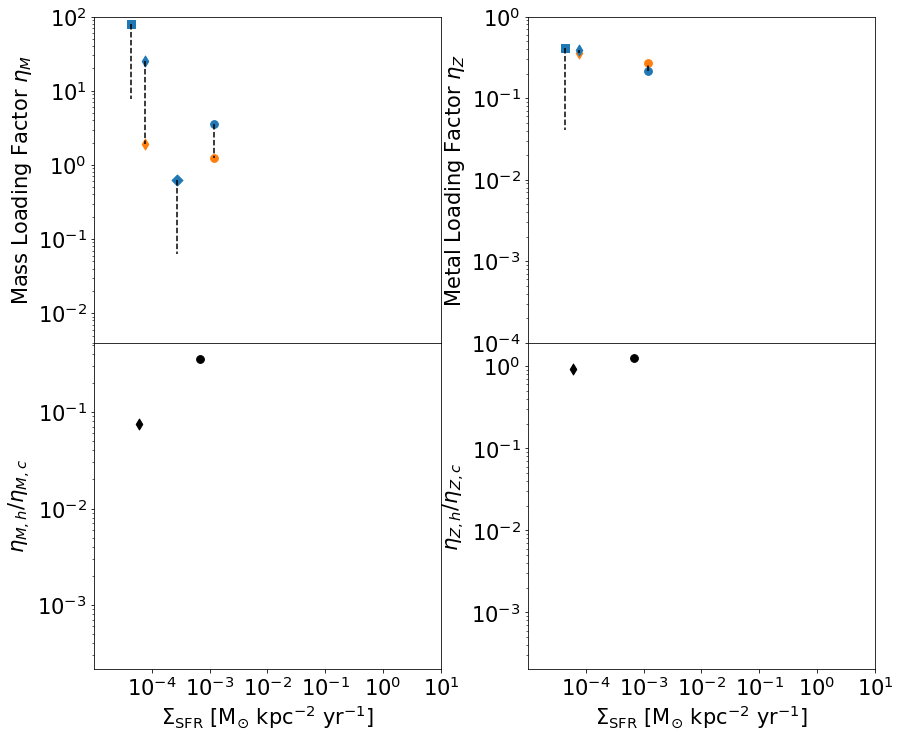

In [83]:
#
#
#
# Li + style loading tables
#
#
fsize = 21
rc('text',usetex=False)
rc('font',size=fsize)



psize = 60
markers = {'sn_only' : 'o',
           'otrad_ion-no-sn' : 's',
           'otrad_no-ion-sn' : 'D',
            'sn_ion-no-otrad' : 'd'}

fig, ax = plt.subplots(2,2,sharex=True)
fig.set_size_inches(14,12)
fig.subplots_adjust(hspace=0,wspace=0.25)

for run in all_data.keys():
    if all_data[run].loading_table_values is None:
        continue

    ax[(0,0)].scatter( all_data[run].loading_table_values['Sigma_sfr'],
                   all_data[run].loading_table_values['Eta_mass_hot'],
                   color = 'C1', s = psize, label = run, marker=markers[run])
    ax[(0,0)].scatter( all_data[run].loading_table_values['Sigma_sfr'],
                   all_data[run].loading_table_values['Eta_mass_cold'],
                   color = 'C0', s = psize, label = run, marker = markers[run])
    yline = [all_data[run].loading_table_values['Eta_mass_cold'],
             all_data[run].loading_table_values['Eta_mass_hot']]
    xline = [ all_data[run].loading_table_values['Sigma_sfr']]*2    
   
    if  yline[1] <= 0.0:
        yline[1] = 0.1 * yline[0]

    ax[(0,0)].plot( xline,
                    yline,
                    lw = 1.5, color = 'black',
                    ls = '--')
    
    ax[(0,1)].scatter( all_data[run].loading_table_values['Sigma_sfr'],
                   all_data[run].loading_table_values['Eta_metal_hot'],
                   color = 'C1', s = psize, label = run, marker=markers[run])
    ax[(0,1)].scatter( all_data[run].loading_table_values['Sigma_sfr'],
                   all_data[run].loading_table_values['Eta_metal_cold'],
                   color = 'C0', s = psize, label = run, marker = markers[run])    
    
    yline = [all_data[run].loading_table_values['Eta_metal_cold'],
             all_data[run].loading_table_values['Eta_metal_hot']]
    xline = [ all_data[run].loading_table_values['Sigma_sfr']]*2    
   
    if  yline[1] <= 0.0:
        yline[1] = 0.1 * yline[0]

    ax[(0,1)].plot( xline,
                    yline,
                    lw = 1.5, color = 'black',
                    ls = '--')
    
    yratio = all_data[run].loading_table_values['Eta_mass_hot'] /\
             all_data[run].loading_table_values['Eta_mass_cold']
    
    ax[(1,0)].scatter( all_data[run].loading_table_values['Sigma_sfr'],
                   yratio,
                   color = 'black', s = psize, label = run, marker = markers[run])
   
    yratio = all_data[run].loading_table_values['Eta_metal_hot'] /\
             all_data[run].loading_table_values['Eta_metal_cold']
    
    ax[(1,1)].scatter( all_data[run].loading_table_values['Sigma_sfr'],
                   yratio,
                   color = 'black', s = psize, label = run, marker = markers[run])
    
    #print(run, all_data[run].loading_table_values['Sigma_sfr'])
    #print(run, all_data[run].loading_table_values['Eta_E_hot'])
    #print(run, all_data[run].loading_table_values['Eta_E_cold'])
    
for a2 in ax:
    for a in a2:
        a.semilogx()
        a.semilogy()
        a.set_xlim(1.0E-5,2)
    
#ax[0].set_ylim(1.0E12,6.0E16)
#ax[1].set_ylim(1.0,3000.0)
#ax[1].legend(loc='best',ncol = 2)
ax[(0,0)].set_ylabel(r"Mass Loading Factor $\eta_M$")
ax[(0,1)].set_ylabel(r"Metal Loading Factor $\eta_Z$")
ax[(1,0)].set_xlabel(r"$\Sigma_{\rm SFR}$ [M$_{\odot}$ kpc$^{-2}$ yr$^{-1}$]")
ax[(1,1)].set_xlabel(r"$\Sigma_{\rm SFR}$ [M$_{\odot}$ kpc$^{-2}$ yr$^{-1}$]")

ax[(1,0)].set_ylabel(r"$\eta_{M,h} / \eta_{M,c}$")

ax[(1,1)].set_ylabel(r"$\eta_{Z,h} / \eta_{Z,c}$")

ax[(1,0)].set_xticks([1.0E-4,1.0E-3,1.0E-2,1.0E-1,1.0,10.0])
ax[(1,1)].set_xticks([1.0E-4,1.0E-3,1.0E-2,1.0E-1,1.0,10.0])

plt.minorticks_on()

ax[(0,0)].set_ylim(0.004,100)
ax[(0,1)].set_ylim(1.0E-4,1.0)

ax[(1,0)].set_ul
#plt.tight_layout()
fig.savefig("phys_comparison_mass_metal_hot_cold_SFR.png")
